# Step 1 Import Data

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math
import seaborn as sns
from my_func import *

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

### Load Data into Pandas

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()
df.drop(columns= ['id', 'bedrooms', 'bathrooms',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'], inplace=True)

# Step 2 Clean the data
Check the data types, to make sure they are correct. For example, it usually does not make sense for a number to be a string.
Make sure the column names are correct. Having the correct column names makes the process of selecting data easier.
Check for and drop/fill missing values. Dropping errors helps to control for errors when running.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         21597 non-null  object 
 1   price        21597 non-null  float64
 2   sqft_living  21597 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 506.3+ KB


### This is only a simple regression looking to see if the living sf can predict the price

We need to make date column the index and a datetime type

All other data types are good.

In [4]:
# set the index equal to the date column & then drop the old date column
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis = 1)

# print the first five rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21597 entries, 2014-10-13 to 2014-10-15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   sqft_living  21597 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 506.2 KB


,price,sqft_living
date,,
2014-10-13,221900.0,1180
2014-12-09,538000.0,2570
2015-02-25,180000.0,770
2014-12-09,604000.0,1960
2015-02-18,510000.0,1680


### Check for Null Values

In [5]:
df.isnull().sum() #no null values present

price          0
sqft_living    0
dtype: int64

In [6]:
df.sqft_living.loc[df.sqft_living < 1000]

date
2015-02-25    770
2015-03-25    990
2014-06-02    960
2014-06-23    880
2015-04-06    770
             ... 
2015-01-20    980
2014-05-09    998
2014-10-15    980
2014-06-23    940
2014-06-10    710
Name: sqft_living, Length: 1414, dtype: int64

# Step 4: Explore the Data
Okay, now that we have a clean dataset let us explore it a little. Again, this is a critical step as it helps us understand some of the following questions:

How is the data distributed?

Does there appear to be a relationship between the two variables?

Are there any outliers?

Is the data skewed?

By better understanding the answers to these questions we can validate whether we need to do further transformations or if we need to change the model we picked.

Here we can see the max data points for both columns price and sqft_living are well over 3 standard devatiations from the mean. This will skew our data to the right with all these outliers.

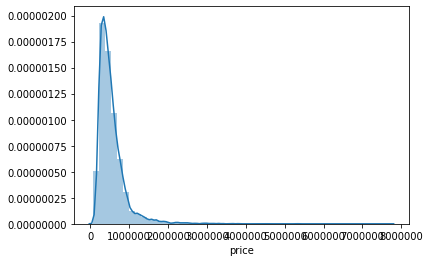

In [7]:
sns.distplot(df.price)

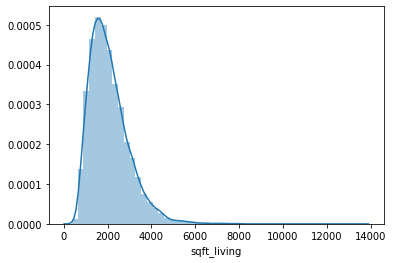

In [8]:
sns.distplot(df.sqft_living)

Here we can see a good visualization of the distributions. The two data points are definitely skewed to the right and have a good bit of outliers.

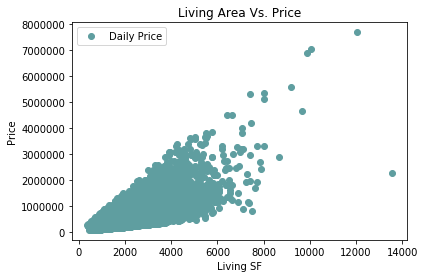

In [9]:
# define the x & y data.
x = df['sqft_living']
y = df['price']

# create the scatter plot.
plt.plot(x, y, 'o', color ='cadetblue', label = 'Daily Price')

# make sure it's formatted.
plt.title("Living Area Vs. Price")
plt.xlabel("Living SF")
plt.ylabel("Price")
plt.legend()

plt.show()

This scatter plot shows there is definitely a strong linear correlation between these two variables.

In [10]:
df.corr()

,price,sqft_living
price,1.000000,0.701917
sqft_living,0.701917,1.000000


There is a correlation (0.7) and a strong one at that. Generally speaking, this is how we measure the strength of correlations.

 - Very strong relationship **(|r| > 0.8 =>)**
 - Strong relationship **(0.6 ≤ |r|)**
 - Moderate relationship **(0.4 ≤ |r|)**
 - Weak relationship **(0.2 ≤ |r|)**
 - Very weak relationship **(|r|)** 


### 4.1 Describe the Data

In [11]:
# get the summary
desc_df = df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,price,sqft_living
count,2.159700e+04,21597.000000
mean,5.402966e+05,2080.321850
std,3.673681e+05,918.106125
min,7.800000e+04,370.000000
25%,3.220000e+05,1430.000000
50%,4.500000e+05,1910.000000
75%,6.450000e+05,2550.000000
max,7.700000e+06,13540.000000
+3_std,1.642401e+06,4834.640225
-3_std,-5.618078e+05,-673.996525


Here we can see that our max value in both columns is well outside 3 standard devations and will really effect our model.

# Step 5 Remove Outliers

In [12]:
# filter the data frame to remove the values exceeding 3 standard deviations
filtered_df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print("The amount of outliers that have been filtered:", filtered_df.shape[0] - df.shape[0])

The amount of outliers that have been filtered: -525


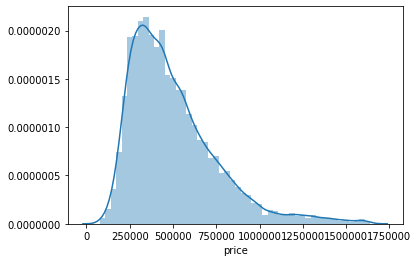

In [13]:
sns.distplot(filtered_df.price)

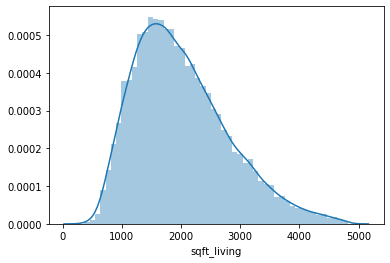

In [14]:
sns.distplot(filtered_df.sqft_living)

These are still skewed, but in reality the data is skewed also so we will leave this as is.

# Step 6 Skewness and Kurtosis Check

In [15]:
# calculate the excess kurtosis using the fisher method. The alternative is Pearson which calculates regular kurtosis.
sqft_living_kurtosis = kurtosis(filtered_df['sqft_living'], fisher = True)
price_kurtosis = kurtosis(filtered_df['price'], fisher = True)

# calculate the skewness
sqft_living_skew = skew(filtered_df['sqft_living'])
price_skew = skew(filtered_df['price'])

display("SQFT Living Excess Kurtosis: {:.2}".format(sqft_living_skew))  # this looks fine
display("Price Excess Kurtosis: {:.2}".format(price_skew))      # this looks fine

display("SQFT Living Skew: {:.2}".format(sqft_living_skew))          # moderately skewed
display("Price Skew: {:.2}".format(price_skew))              # moderately skewed, it's a little high but we will accept it.

'SQFT Living Excess Kurtosis: 0.73'

'Price Excess Kurtosis: 1.4'

'SQFT Living Skew: 0.73'

'Price Skew: 1.4'

**Kurtosis**
- Any distribution with **kurtosis ≈3 (excess ≈0)** is called mesokurtic. This is a normal distribution
- Any distribution with **kurtosis <3 (excess kurtosis <0)** is called platykurtic. Tails are shorter and thinner, and often its central peak is lower and broader.
- Any distribution with **kurtosis >3 (excess kurtosis >0)** is called leptokurtic. Tails are longer and fatter, and often its central peak is higher and sharper.

***

**Skewness**
- If skewness is **less than −1 or greater than +1**, the distribution is highly skewed.
- If skewness is **between −1 and −½ or between +½ and +1**, the distribution is moderately skewed.
- If skewness is **between −½ and +½**, the distribution is approximately symmetric.

**Conclusion**

Kurtosis - both data sets have more thab 0.5 excess kurtosis.

Skew - Price has a skewness > 1 so this is considered highly skewed and may need to be transformed.

The larger the dataset the higher the more skewed and kurtosis your data set will become. This is a relatively large data set so it is not surprising we see skew and kurtosis. We may come back and do a log transformation on the data later to try to make it more normal.

# Step 7 Build the Model

### 7.1 Split the Data

In [16]:
# define our input variable (X) & output variable.
Y = filtered_df[['price']]
X = filtered_df[['sqft_living']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

Typical training:test splits are 80:20.

### 7.2 Create and Fit Model

In [17]:
# create a Linear Regression model object.
regression_model = LinearRegression()

# pass through the X_train & y_train data set.
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 7.3 Explore the Output

In [18]:
# let's grab the coefficient of our model and the intercept.
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("The Coefficient for our model is {:.4}".format(coefficient))
print("The intercept for our model is {:.6}".format(intercept))

The Coefficient for our model is 209.3
The intercept for our model is 82510.5


Interpreting the coefficient, we would say that for every sf increase in area **is associated with a 209.3** increase in the price. **We are NOT CLAIMING CAUSATION, just association.**

### 7.4 Test by Making a Prediction

In [19]:
# let's test a prediction
prediction = regression_model.predict([[1200]])
predicted_value = prediction[0][0]
print("The predicted value is {:.8}".format(predicted_value),"dollars.")

The predicted value is 333655.41 dollars.


### 7.4.1 Make Multiple Predicitions

In [20]:
# Get multiple predictions.
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[434113.36279054],
       [450856.35555287],
       [526199.82298337],
       [850595.3077536 ],
       [383884.38450353]])

# Step 8 Evaluate the Model

To make this process easier on ourselves, we are going to recreate our same model using the statsmodel.api library. The reason why is that they have numerous built-in functions that make calculating metrics like confidence intervals and p-values a breeze. The output from the statsmodel.api will not be identical to our sklearn library but it will be very close.

In [21]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model.
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

### 8.1 Model Summary

In [22]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 1.546e+04
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:00:11   Log-Likelihood:            -2.8636e+05
No. Observations:               21072   AIC:                         5.727e+05
Df Residuals:                   21070   BIC:                         5.727e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.479e+04   3618.118     23.435      

### 8.2 Confidence Interval

In [23]:
est.conf_int()

,0,1
const,77697.577117,91881.152859
sqft_living,204.600476,211.153730


Interpreting the output above, we would say that with 95% confidence the sqft_living coefficient exists between 204.6 & 211.15

### 8.3 Hypothesis Testing

- **Null Hypothesis:** There is no relationship between the sqft_living and the price.
    - The coefficient equals 0.
- **Alternative Hypothesis:** There is a relationship between the sqft_living and the price.
    - The coefficient does not equal to 0.
    
- If we reject the null, we are saying there is a relationship, and the coefficient does not equal 0.
- If we fail to reject the null, we are saying there is no relationship, and the coefficient does equal 0.

In [24]:
est.pvalues

const          6.469811e-120
sqft_living     0.000000e+00
dtype: float64

The p-value represents the probability that the coefficient equals 0. We want a p-value that is less than 0.05 if it is we can reject the null hypothesis. In this case, the p-value for the sqft_living coefficient is much lower than 0.05, so we can reject the null hypothesis and say that there is a relationship and that we believe it to be between the sqft_living and the price.

### 8.4 Model Fit

We will take `y_predictions` and compare them to our `y_actuals` these will be our residuals. From here we can calculate a few metrics to help quantify how well our model fits the data. Here are a few popular metrics:

- **Mean Absolute Error (MAE):** Is the mean of the absolute value of the errors. This metric gives an idea of magnitude but no idea of direction (too high or too low).

- **Mean Squared Error (MSE):** Is the mean of the squared errors.MSE is more popular than MAE because MSE "punishes" more significant errors.

- **Root Mean Squared Error (RMSE):** Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

In [25]:
# calculate the mean squared error.
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error.
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:}".format(model_mse))
print("MAE {:}".format(model_mae))
print("RMSE {:}".format(model_rmse))

MSE 36924809884.67193
MAE 145382.38907042964
RMSE 192158.29382223377


### 8.4.1 R-Squared
The R-Squared metric provides us a way to measure the goodness of fit or how well our data fits the model. The higher the R-Squared metric, the better the data fit our model. However, we have to know the limitations of R-Square. One limitation is that R-Square increases as the number of feature increases in our model, so it does not pay to select the model with the highest R-Square. A more popular metric is the adjusted R-Square which penalizes more complex models. Let us calculate both.

In [26]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.41


With R-Square & adjusted R-Square, we have to be careful when interpreting the output because it depends on what our the goal is. The R-squared is generally of secondary importance unless the main concern is using the regression equation to make accurate predictions. It boils down to the domain-specific problem

### Step 9 Visualize the Model

### 9.1 Plot the Residuals

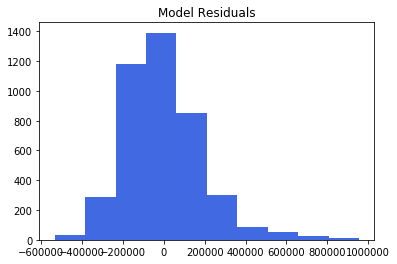

In [27]:
# Grab the residuals & then call the hist() method
(y_test - y_predict).hist(grid = False, color = 'royalblue')
plt.title("Model Residuals")
plt.show()

### 9.2 Plot the line

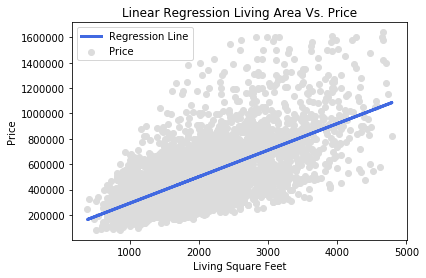

sqft_living coefficient:209.28740952917812
Mean squared error: 36924809884.67193
Root Mean squared error: 192158.3
R2 score: 0.41


In [28]:
# Plot outputs
plt.scatter(X_test, y_test,  color='gainsboro', label = 'Price')
plt.plot(X_test, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression Living Area Vs. Price")
plt.xlabel("Living Square Feet")
plt.ylabel("Price")
plt.legend()
plt.show()

# The coefficients
print('sqft_living coefficient:' + '\033[1m' + '{:}''\033[0m'.format(regression_model.coef_[0][0]))

# The mean squared error
print('Mean squared error: ' + '\033[1m' + '{:}''\033[0m'.format(model_mse))

# The mean squared error
print('Root Mean squared error: ' + '\033[1m' + '{:.7}''\033[0m'.format(math.sqrt(model_mse)))

# Explained variance score: 1 is perfect prediction
print('R2 score: '+ '\033[1m' + '{:.2}''\033[0m'.format(r2_score(y_test,y_predict)))

### Step 10 Save the Model for later use

In [29]:
import pickle

# pickle the model.
with open('sgft_price_linreg.sav','wb') as f:
     pickle.dump(regression_model,f)

# load it back in to see if everything works
with open('sgft_price_linreg.sav', 'rb') as pickle_file:
     regression_model_2 = pickle.load(pickle_file)

# make a new prediction to verify
regression_model_2.predict([[1000]])

array([[291797.92431069]])